In [28]:
%matplotlib inline
import tensorflow as tf
import input_data # defined function to load data
import numpy as np
import matplotlib.pyplot as plt

## Import MINST data
This data contains 3 sets: training set (*mnist.train*) of 55000 samples, validation set (*mnist.validation*) of 5000 samples, and testing set (*mnist.test*) of 10000 samples. In each set, one sample contains an image of size 784 (28x28), a label of size 10 (all zeros except one).

In [4]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


(55000, 784)
(5000, 10)
10000


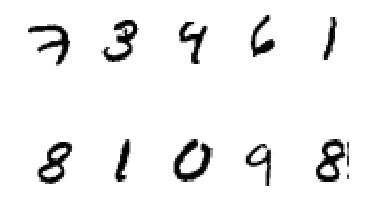

In [29]:
print np.shape(mnist.train.images)
print np.shape(mnist.validation.labels)
print mnist.test.num_examples

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.imshow(np.reshape(mnist.train.images[i],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

## Convolution network

In [21]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 20

In [4]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

In [5]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [6]:
# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1, k=2)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)

    # Convolution Layer
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k=2)
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

In [7]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])), 
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])), 
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [8]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [9]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [10]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
# Initializing the variables
init = tf.initialize_all_variables()

In [12]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], 
                                                             y: mnist.test.labels[:256], 
                                                             keep_prob: 1.})

Iter 2560, Minibatch Loss= 17023.398438, Training Accuracy= 0.36719
Iter 5120, Minibatch Loss= 10436.586914, Training Accuracy= 0.50000
Iter 7680, Minibatch Loss= 9447.187500, Training Accuracy= 0.65625
Iter 10240, Minibatch Loss= 4775.746094, Training Accuracy= 0.74219
Iter 12800, Minibatch Loss= 8045.075195, Training Accuracy= 0.71875
Iter 15360, Minibatch Loss= 2367.890869, Training Accuracy= 0.84375
Iter 17920, Minibatch Loss= 2176.439209, Training Accuracy= 0.85156
Iter 20480, Minibatch Loss= 2778.867676, Training Accuracy= 0.82031
Iter 23040, Minibatch Loss= 1966.031860, Training Accuracy= 0.89844
Iter 25600, Minibatch Loss= 2016.759033, Training Accuracy= 0.82031
Iter 28160, Minibatch Loss= 2252.095215, Training Accuracy= 0.85156
Iter 30720, Minibatch Loss= 1345.925293, Training Accuracy= 0.86719
Iter 33280, Minibatch Loss= 2039.504150, Training Accuracy= 0.87500
Iter 35840, Minibatch Loss= 473.838684, Training Accuracy= 0.93750
Iter 38400, Minibatch Loss= 422.729767, Training A